In [ ]:
from pathlib import Path
import sys

repo_root = Path.cwd().parent  # parent of ml_backtest/
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

In [ ]:
from __future__ import annotations
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from ml_backtest.a_data_loader import load_data
from ml_backtest.g_walkforward import walkforward_run, prepare_walkforward_inputs
from ml_backtest.c_metrics import summarise, sharpe
from ml_backtest.h_mc_permutation import mc_permutation_pvalue, block_permute
from ml_backtest.i_runs_test import runs_test
from ml_backtest.j_outputs import show_backtest_report, plot_equity_and_dd, plot_fold_metrics

In [ ]:
def load_cfg(config="configs/ml_lg.yaml"):
    if isinstance(config, (str, Path)):
        p = Path(config)
        with p.open("r") as f:
            cfg = yaml.safe_load(f)
        cfg["_config_path"] = str(p.resolve())
        return cfg
    elif isinstance(config, dict):
        return config
    else:
        raise TypeError("config must be a path or dict")

In [4]:
"""Load configuration and seed RNG."""
cfg = load_cfg("configs/ml_lg.yaml")

seed = cfg.get("seed", 5)
rng = np.random.default_rng(seed)
tag = cfg.get("output", {}).get("tag", "run")

cfg_overview = pd.DataFrame(
    {
        "value": [
            cfg.get("data", {}).get("source"),
            cfg.get("data", {}).get("ticker"),
            f"{cfg.get('data', {}).get('start')} → {cfg.get('data', {}).get('end')}",
            cfg.get("data", {}).get("interval"),
            cfg.get("strategy", {}).get("name"),
            cfg.get("walkforward", {}).get("min_train"),
            cfg.get("walkforward", {}).get("test_size"),
        ]
    },
    index=[
        "Data source",
        "Ticker",
        "Date range",
        "Interval",
        "Strategy",
        "Train window (days)",
        "Test window (days)",
    ],
)
cfg_overview

,value
Data source,yahoo
Ticker,BTC-USD
Date range,2018-01-01 → 2025-08-31
Interval,1d
Strategy,ml_classifier
Train window (days),730
Test window (days),120


In [26]:
"""Load raw data and show coverage."""
df = load_data(cfg)

data_overview = pd.DataFrame(
    {
        "start": [df.index.min().strftime("%Y-%m-%d")],
        "end": [df.index.max().strftime("%Y-%m-%d")],
        "rows": [len(df)],
        "columns": [len(df.columns)],
    }
).T
data_overview.columns = ["value"]
display(data_overview)
df.head()

,value
start,2018-01-01
end,2025-08-30
rows,2799
columns,7


Price,Open,High,Low,Close,Adj Close,Volume,ret
Ticker,Btc-Usd,Btc-Usd,Btc-Usd,Btc-Usd,Btc-Usd,Btc-Usd,
Date,,,,,,,
2018-01-01 00:00:00+00:00,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN
2018-01-02 00:00:00+00:00,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,0.092589
2018-01-03 00:00:00+00:00,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,0.014505
2018-01-04 00:00:00+00:00,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,0.025858
2018-01-05 00:00:00+00:00,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,0.110945


In [ ]:
"""Prepare features/labels for walkforward and inspect."""
price, Xy = prepare_walkforward_inputs(cfg, df)
feature_cols = [c for c in Xy.columns if c != "y"]

feature_overview = pd.DataFrame(
    {
        "Rows": [len(Xy)],
        "Feature count": [len(feature_cols)],
        "First date": [Xy.index.min().strftime("%Y-%m-%d")],
        "Last date": [Xy.index.max().strftime("%Y-%m-%d")],
    }
)
display(feature_overview)
Xy[feature_cols + ["y"]].head()

,Rows,Feature count,First date,Last date
0,2699,4,2018-04-11,2025-08-30


,vol_60,rsi_14,dist_sma_100,donch_pos,y
Date,,,,,
2018-04-11 00:00:00+00:00,0.048982,39.820343,-0.312560,-0.418726,1
2018-04-12 00:00:00+00:00,0.051131,52.906122,-0.216224,-0.249177,1
2018-04-13 00:00:00+00:00,0.049622,52.986336,-0.209823,-0.247941,1
2018-04-14 00:00:00+00:00,0.049431,54.118686,-0.194653,-0.231320,1
2018-04-15 00:00:00+00:00,0.047994,58.233122,-0.152298,-0.168195,0


In [ ]:
"""Run walkforward backtest and collect artefacts."""
folds_df, oos_ret, oos_pos, oos_eq, fold_artifacts = walkforward_run(cfg, df, rng, collect_debug=True)
summary = summarise(oos_ret, oos_pos)
observed_sharpe = sharpe(oos_ret)
z_run, p_run = runs_test(oos_ret)

folds_df

,ann_return_log,sharpe,sortino,max_dd,calmar,profit_factor,hit_rate,exposure,turnover,var_5,es_5,start,end
0,0.282609,2.403151,2.744949,-0.022646,12.479500,4.019575,0.134454,0.210084,1.286886,-0.001695,-0.006760,2020-04-10,2020-08-07
1,0.306799,1.740410,1.790535,-0.087750,3.496285,1.477564,0.403361,0.680672,3.228586,-0.013940,-0.028131,2020-08-08,2020-12-05
2,0.000000,0.000000,0.000000,0.000000,0.000000,inf,0.000000,0.000000,0.000000,-0.000000,0.000000,2020-12-06,2021-04-04
3,-0.011247,-0.134625,-0.090547,-0.071658,-0.156953,0.948618,0.092437,0.201681,2.314771,-0.005103,-0.014261,2021-04-05,2021-08-02
4,0.104464,0.943384,0.631911,-0.045921,2.274894,2.015027,0.025210,0.050420,4.024233,-0.000000,-0.000419,2021-08-03,2021-11-30
5,-0.043922,-0.684540,-0.407330,-0.066868,-0.656845,0.778643,0.126050,0.243697,2.279636,-0.004905,-0.012775,2021-12-01,2022-03-30
6,-0.103633,-0.996648,-0.732951,-0.102128,-1.014741,0.741538,0.184874,0.361345,2.036870,-0.009018,-0.020716,2022-03-31,2022-07-28
7,-0.164323,-0.951618,-0.568096,-0.105713,-1.554428,0.711701,0.184874,0.327731,5.571823,-0.008440,-0.036479,2022-07-29,2022-11-25
8,-0.398960,-3.203533,-2.159313,-0.198847,-2.006369,0.314597,0.126050,0.310924,2.978666,-0.015072,-0.029991,2022-11-26,2023-03-25
9,0.087758,1.565197,1.366467,-0.021153,4.148676,1.614056,0.168067,0.260504,4.390967,-0.003522,-0.008969,2023-03-26,2023-07-23


In [ ]:
"""Per-fold policy and classifier diagnostics."""
policy_rows = []
for idx, fold in enumerate(fold_artifacts, 1):
    policy_rows.append(
        {
            "fold": idx,
            "start": fold.oos_metrics.get("start"),
            "end": fold.oos_metrics.get("end"),
            "threshold": fold.threshold,
            "min_hold": fold.min_hold,
            "train_sharpe": fold.train_metrics.get("sharpe"),
            "train_exposure": fold.train_metrics.get("exposure"),
            "oos_sharpe": fold.oos_metrics.get("sharpe"),
            "oos_exposure": fold.oos_metrics.get("exposure"),
            "oos_hit_rate": fold.oos_metrics.get("hit_rate"),
        }
    )
fold_policy = pd.DataFrame(policy_rows).set_index("fold") if policy_rows else pd.DataFrame()
fold_policy

,start,end,threshold,min_hold,train_sharpe,train_exposure,oos_sharpe,oos_exposure,oos_hit_rate
fold,,,,,,,,,
1,2020-04-10,2020-08-07,0.53,5,0.287882,0.253425,2.403151,0.210084,0.134454
2,2020-08-08,2020-12-05,0.53,3,1.725413,0.421918,1.740410,0.680672,0.403361
3,2020-12-06,2021-04-04,0.55,1,0.850485,0.010959,0.000000,0.000000,0.000000
4,2021-04-05,2021-08-02,0.52,1,2.158893,0.506849,-0.134625,0.201681,0.092437
5,2021-08-03,2021-11-30,0.53,3,1.308628,0.286301,0.943384,0.050420,0.025210
6,2021-12-01,2022-03-30,0.55,1,1.876034,0.282192,-0.684540,0.243697,0.126050
7,2022-03-31,2022-07-28,0.55,3,1.587400,0.265753,-0.996648,0.361345,0.184874
8,2022-07-29,2022-11-25,0.54,5,0.774884,0.213699,-0.951618,0.327731,0.184874
9,2022-11-26,2023-03-25,0.53,1,1.349246,0.332877,-3.203533,0.310924,0.126050


/var/folders/7x/vbxdft1s57l5cr0yysdtt8c80000gn/T/ipykernel_17856/4228595342.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration_table = prob_df.groupby("bucket").agg(


,mean_proba,hit_rate,observations
bucket,,,
"(0.2, 0.3]",0.289962,0.000000,1
"(0.3, 0.4]",0.317636,0.666667,15
"(0.4, 0.5]",0.475073,0.557377,61
"(0.5, 0.6]",0.530246,0.500000,42
"(0.6, 0.7]",0.602387,1.000000,1


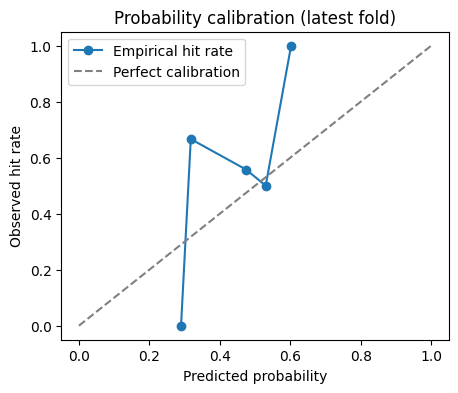

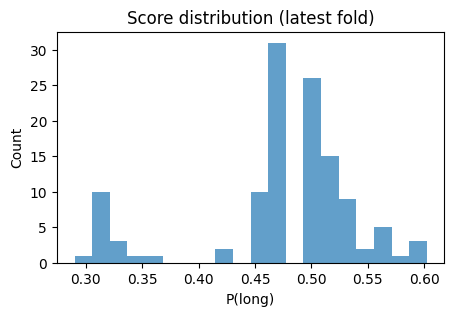

In [ ]:
"""Inspect classifier probability calibration on the latest fold."""
if fold_artifacts:
    latest_fold = fold_artifacts[-1]
    y_test = Xy.loc[latest_fold.test_index, "y"]
    proba_test = latest_fold.proba_test
    prob_df = pd.DataFrame({"prob": proba_test, "actual": y_test})
    prob_df["bucket"] = pd.cut(prob_df["prob"], bins=np.linspace(0, 1, 11), include_lowest=True)
    calibration_table = prob_df.groupby("bucket").agg(
        mean_proba=("prob", "mean"),
        hit_rate=("actual", "mean"),
        observations=("actual", "size"),
    ).dropna()
    display(calibration_table)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(calibration_table["mean_proba"], calibration_table["hit_rate"], marker="o", label="Empirical hit rate")
    ax.plot([0, 1], [0, 1], "--", color="grey", label="Perfect calibration")
    ax.set(title="Probability calibration (latest fold)", xlabel="Predicted probability", ylabel="Observed hit rate")
    ax.legend()
    plt.show()

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.hist(prob_df["prob"], bins=20, alpha=0.7)
    ax.set(title="Score distribution (latest fold)", xlabel="P(long)", ylabel="Count")
    plt.show()
else:
    print("No folds generated.")

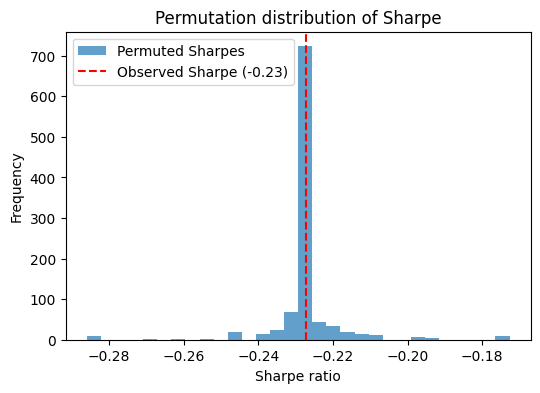

{'manual': 0.8201798201798202, 'function': 0.8201798201798202}

In [ ]:
"""Monte Carlo permutation distribution of Sharpe."""
perm_iterations = 1000
perm_rng = np.random.default_rng(seed)
perm_sharpes = []
arr = oos_ret.values
for _ in range(perm_iterations):
    perm = block_permute(arr, block=5, rng=perm_rng)
    perm_sharpes.append(sharpe(pd.Series(perm, index=oos_ret.index)))
perm_sharpes = np.array(perm_sharpes)
pval_manual = float((np.sum(perm_sharpes >= observed_sharpe) + 1) / (perm_iterations + 1))
pval = mc_permutation_pvalue(oos_ret, n_iter=perm_iterations, block=5, seed=seed)

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(perm_sharpes, bins=30, alpha=0.7, label="Permuted Sharpes")
ax.axvline(observed_sharpe, color="red", linestyle="--", label=f"Observed Sharpe ({observed_sharpe:.2f})")
ax.set(title="Permutation distribution of Sharpe", xlabel="Sharpe ratio", ylabel="Frequency")
ax.legend()
plt.show()
{"manual": pval_manual, "function": pval}

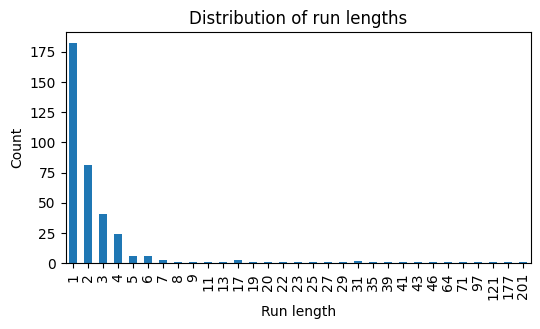

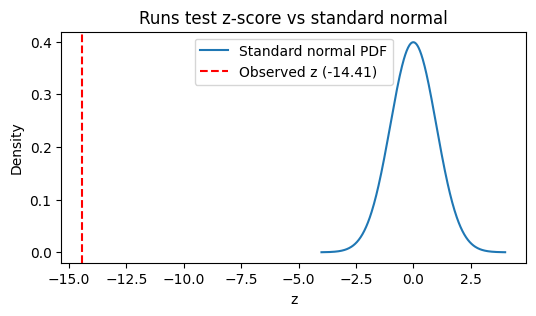

In [ ]:
"""Runs test diagnostics."""
if np.isnan(z_run):
    print("Runs test undefined (all returns share the same sign).")
else:
    sign_series = pd.Series(np.where(oos_ret > 0, 1, -1), index=oos_ret.index)
    runs = (sign_series != sign_series.shift()).cumsum()
    run_lengths = sign_series.groupby(runs).size()

    fig, ax = plt.subplots(figsize=(6, 3))
    run_lengths.value_counts().sort_index().plot(kind="bar", ax=ax)
    ax.set(title="Distribution of run lengths", xlabel="Run length", ylabel="Count")
    plt.show()

    x = np.linspace(-4, 4, 400)
    pdf = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(x, pdf, label="Standard normal PDF")
    ax.axvline(z_run, color="red", linestyle="--", label=f"Observed z ({z_run:.2f})")
    ax.set(title="Runs test z-score vs standard normal", xlabel="z", ylabel="Density")
    ax.legend()
    plt.show()
    (z_run, p_run)

In [ ]:
"""Assemble summary payload and render standard report."""
summary_out = {
    "config": cfg,
    "summary": summary,
    "mc_permutation_pvalue": pval,
    "runs_test_z": z_run,
    "runs_test_p": p_run,
}
show_backtest_report(summary_out)

# Backtest Summary — ml_lg

## Metrics

Metric,Value,Target
Ann. return (arith),-2.70%,≥ 8%
Sharpe,-0.23,≥ 0.90
Sortino,-0.18,≥ 1.20
Max drawdown,-44.6%,≥ −25%
Calmar,-0.06,≥ 1.00
Profit factor,0.93,≥ 1.30
Hit rate,17.5%,≥ 53%
Exposure,34.6%,20%–60%
Turnover,64.8,≤ 100
VaR 5%,-0.95%,≥ −3%


## Statistical Tests

Test,Value,Target
MC permutation p-value,0.8202,≤ 0.01
Runs test z,-14.41,∣z∣ ≤ 2.0
Runs test p,0.0000,≥ 0.05


## Config

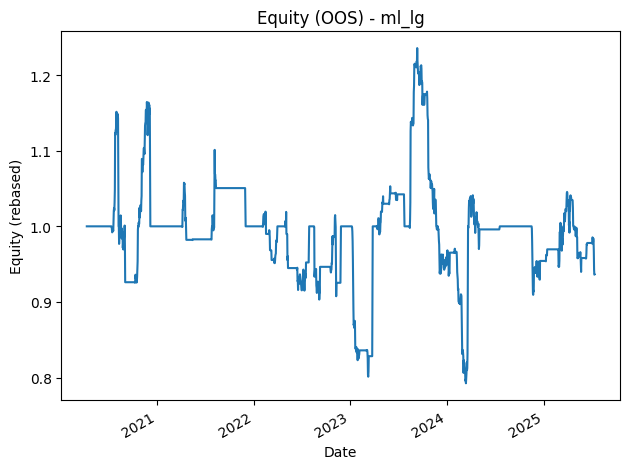

In [ ]:
plot_equity_and_dd(oos_eq, f"Equity (OOS) - {tag}")

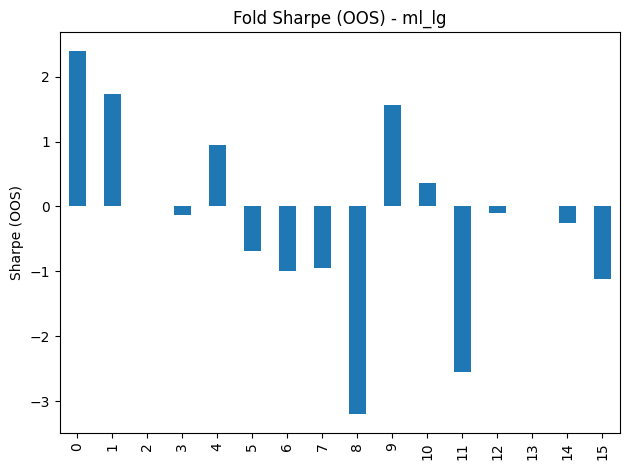

In [ ]:
plot_fold_metrics(folds_df, f"Fold Sharpe (OOS) - {tag}")